In [2]:

import nltk
from nltk import pos_tag, word_tokenize, sent_tokenize
from nltk.chunk import ne_chunk

from rdflib import Graph, URIRef, Namespace
from rdflib.plugins.sparql import prepareQuery

import networkx as nx
import matplotlib.pyplot as plt

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("maxent_ne_chunker")
nltk.download("words")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\najmulu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\najmulu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\najmulu\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\najmulu\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:
# Function to extract entities and relationships
def extract_entities_and_relationships(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    entities = []
    relationships = []
    

    tree = ne_chunk(tagged)
    
    # Extract entities (nouns via NER chunks)
    for subtree in tree:
        if hasattr(subtree, 'label'):
            entity = " ".join([word for word, tag in subtree.leaves()])
            entities.append(entity)
    
    # Extract relationships (verbs)
    for word, pos in tagged:
        if pos.startswith('VB'):  # Verbs represent relationships
            relationships.append(word)
    
    return entities, relationships

sentences_text = "Bob lives in Beijing."
entities, relationships = extract_entities_and_relationships(sentences_text)
print("Entities:", entities, "Relationships:", relationships)


Entities: ['Bob', 'Beijing'] Relationships: ['lives']


In [4]:
# Function to create the knowledge graph
def build_knowledge_graph(entities, relationships):
    g = Graph()
    EX = Namespace("http://example.org/")
    # Basic example: Assuming entity1 is subject, relationship is predicate, and entity2 is object
    for i in range(min(len(relationships), len(entities) - 1)):
        subject = URIRef(EX[entities[i]])
        predicate = URIRef(EX[relationships[i]])
        obj = URIRef(EX[entities[i + 1]])
        g.add((subject, predicate, obj))
    return g

# Build the graph from the single sentence
g = build_knowledge_graph(entities, relationships)

# Print the graph in turtle format
print(g.serialize(format='turtle'))


@prefix ns1: <http://example.org/> .

ns1:Bob ns1:lives ns1:Beijing .




In [5]:
query = prepareQuery('''
  SELECT ?subject ?predicate ?object
  WHERE {
    ?subject ?predicate ?object .
  }
''')

# Execute the query
for row in g.query(query):
    print(f"{row.subject} {row.predicate} {row.object}")


http://example.org/Bob http://example.org/lives http://example.org/Beijing


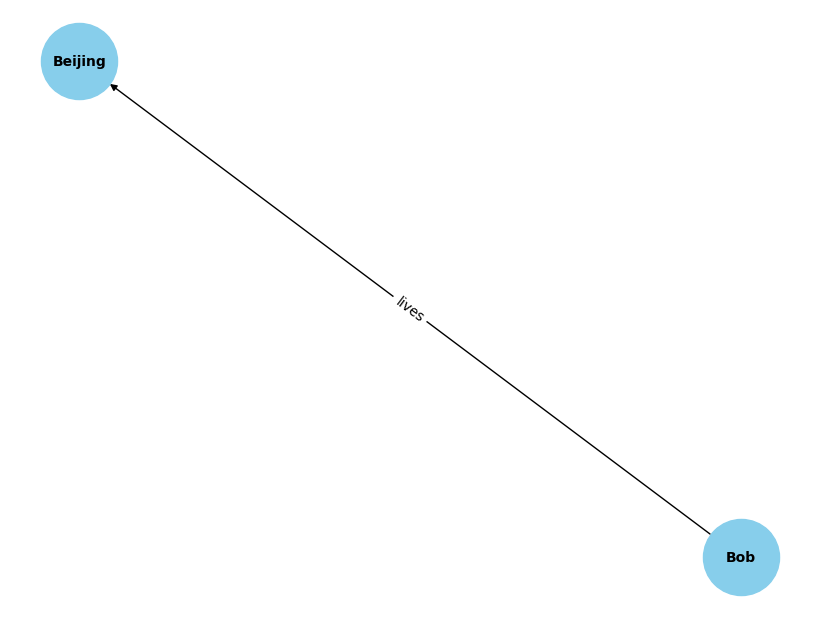

In [6]:
def visualize_knowledge_graph(graph):
    G = nx.DiGraph()

    # Add triples as edges in the NetworkX graph
    for s, p, o in graph:
        G.add_edge(str(s).split('/')[-1], str(o).split('/')[-1], label=str(p).split('/')[-1])

    pos = nx.spring_layout(G)
    
    # Plot the graph
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3000,
            font_size=10, font_weight='bold', arrows=True)

    # Add edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.show()

# Visualize the graph
visualize_knowledge_graph(g)


@prefix ns1: <http://example.org/> .

ns1:Alice ns1:lives ns1:Sydney .

ns1:Bob ns1:lives ns1:Beijing .

ns1:Jordan ns1:lives ns1:Paris .


http://example.org/Bob http://example.org/lives http://example.org/Beijing
http://example.org/Alice http://example.org/lives http://example.org/Sydney
http://example.org/Jordan http://example.org/lives http://example.org/Paris


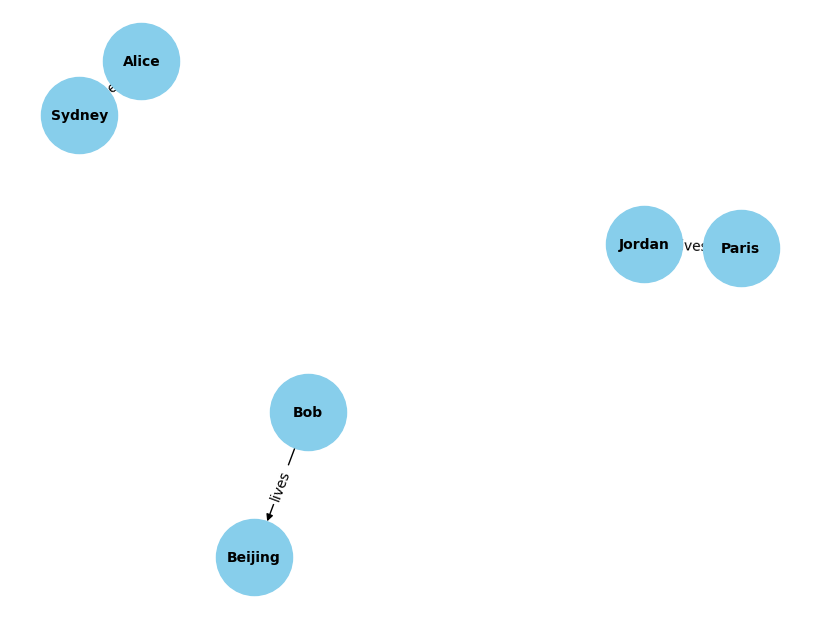

In [7]:
# Multi-sentence input 
sentences_text = "Bob lives in Beijing. Alice lives in Sydney. Jordan lives in Paris"

# Build a combined KG by processing each sentence separately
g_multi = Graph()
EX = Namespace("http://example.org/")

# Split into sentences and process each
for sent in sent_tokenize(sentences_text):
    ents, rels = extract_entities_and_relationships(sent)
    g_sent = build_knowledge_graph(ents, rels)
    for triple in g_sent:
        g_multi.add(triple)

# Show the combined graph in Turtle
print(g_multi.serialize(format='turtle'))

# SPARQL over the combined graph
for row in g_multi.query(query):
    print(f"{row.subject} {row.predicate} {row.object}")

# Visualize the combined graph
visualize_knowledge_graph(g_multi)
